# Demo Notebook for Creating an Analysis of Reboot Motion Time Series Data

__[CoLab Notebook Link](https://githubtocolab.com/RebootMotion/reboot-toolkit/blob/main/examples/RebootMotionAnalysis.ipynb)__

Run the cells in order, making sure to enter AWS credentials in the cell when prompted

In [1]:
#@title Import Python Libraries

import awswrangler as wr
import reboot_toolkit as rtk
import matplotlib.pyplot as plt
import os
import pandas as pd

from reboot_toolkit import S3Metadata, MocapType, MovementType, Handedness, FileType, PlayerMetadata
from IPython.display import display

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#@title AWS Credentials

# Upload your Organization's .env file to the local file system, per https://pypi.org/project/python-dotenv/
# OR input your credentials string generated by the Reboot Dashboard

boto3_session = rtk.setup_aws()

Org ID:
org-test

Current Boto3 Session:
Session(region_name='us-west-1')


In [9]:
#@title User Input - No code changes required below this section, just enter information in forms

# Update the below info to match your desired analysis information
# Common changes you might want to make:

# To analyze both Hawk-Eye HFR data from the Stats API,
# and also Hawk-Eye Action files (e.g. from the DSP),
#  set mocap_types=[MocapType.HAWKEYE_HFR, MocapType.HAWKEYE]

# To analyze baseball-hitting,
# set movement_type=MovementType.BASEBALL_HITTING

# To analyze right-handed players,
# set handedness=Handedness.RIGHT

# To analyze data from the momentum and energy files,
# set file_type=FileType.MOMENTUM_ENERGY

# See https://docs.rebootmotion.com/ for all available file types and the data in each
mocap_types = [MocapType.REBOOT_MOTION]
movement_type = MovementType.VERTICAL_JUMPING
handedness = Handedness.RIGHT
file_type = FileType.INVERSE_KINEMATICS

# Update the label to whatever you'd like to be displayed in the visuals
primary_segment_label = 'Primary Segment'
comparison_segment_label = 'Comparison Segment'

In [11]:
#@title Set S3 File Info

s3_metadata = S3Metadata(
    org_id=os.environ['ORG_ID'],
    mocap_types=mocap_types,
    movement_type=movement_type,
    handedness=handedness,
    file_type=file_type,
)

s3_df = rtk.download_s3_summary_df(s3_metadata)

Available data...

last_modified
['2023-03-30 22:41:50.659246' '2023-03-30 22:25:38.880486'
 '2023-03-30 22:30:00.200120' '2023-03-30 22:24:32.350520'
 '2023-03-30 22:45:55.675257' '2023-03-30 22:30:23.863081'
 '2023-03-30 22:31:21.221353' '2023-03-30 22:42:19.010233'
 '2023-03-30 22:42:47.853658' '2023-03-30 22:30:52.558392'
 '2022-02-07 17:14:57.415221' '2022-02-11 01:33:25.658356'
 '2022-02-11 01:37:45.144051' '2022-02-11 01:37:22.504171'
 '2022-02-12 07:22:51.093286' '2022-02-11 01:31:02.589916'
 '2022-02-11 05:46:23.306440' '2022-02-11 05:45:12.303545'
 '2022-02-11 05:57:48.246931' '2022-02-12 06:05:26.256659'
 '2022-02-11 06:02:06.620570' '2022-02-11 06:03:24.511639'
 '2022-02-11 06:03:50.896250' '2022-02-12 06:04:51.905901'
 '2022-02-11 06:11:27.449727' '2022-02-12 06:12:57.988370'
 '2022-02-11 06:16:28.087013' '2022-02-12 06:07:11.819705'
 '2022-02-12 06:05:09.299536' '2022-02-11 06:21:26.588517'
 '2022-02-11 06:24:54.491003' '2022-02-12 06:05:16.697638'
 '2022-02-11 06:32:47.4

In [5]:
#@title Optional Look Up Player ID by Name

name_to_look_up = "Jacob deGrom"

rtk.find_player_matches(s3_df, name_to_look_up, match_threshold=50., max_results=5)

,first_name,last_name,org_player_id,name,match
0,Jacob,McGee,459429,jacob mcgee,60.869565
1,Jace,Peterson,607054,jace peterson,56.000000
2,Jimmy,Cordero,622772,jimmy cordero,56.000000
3,Robert,Grossman,543257,robert grossman,51.851852
4,Geraldo,Perdomo,672695,geraldo perdomo,51.851852


In [6]:
#@title Display the Interface for Selecting the Primary Data Segment to Analyze

# Run this cell to display the dropdown menus and reset all options to NULL
primary_segment_widget = rtk.create_interactive_widget(s3_df)
display(primary_segment_widget)

In [38]:
#@title Set Primary Analysis Segment Info

primary_segment_data = primary_segment_widget.children[1].result
primary_analysis_segment = PlayerMetadata(
    org_player_ids=primary_segment_data["org_player_ids"],
    session_dates=primary_segment_data["session_dates"],
    session_nums=primary_segment_data["session_nums"],
    session_date_start=primary_segment_data["session_date_start"],
    session_date_end=primary_segment_data["session_date_end"],
    year=primary_segment_data["year"],
    org_movement_id=None, # set the play GUID for the skeleton animation; None defaults to the first play
    s3_metadata=s3_metadata,
)

primary_segment_summary_df = rtk.filter_s3_summary_df(primary_analysis_segment, s3_df)

# Common Issue:
# If no data files are returned here,
# check that the segment selection widget and the S3 File Info above are set correctly,
# also if the cells were updated after running once, check that they were run again with any new selections.

# List all Available S3 data for the Primary Analysis Segment
available_s3_keys = rtk.list_available_s3_keys(os.environ['ORG_ID'], primary_segment_summary_df)
# Load the Primary Analysis Segment into an Analysis Dictionary with Mean and Standard Dev DataFrames
primary_segment_data_df = rtk.load_games_to_df_from_s3_paths(primary_segment_summary_df['s3_path_delivery'].tolist())

# Common Issue:
# Missing element: data integrity issues in parsing. Majority of data is still likely fine.
# Common metrics to filter by are: start_speed, end_speed, spin_rate, spin_direction, zone, pitch_type

Available data...

last_modified
['2024-11-07 02:08:46.886950']

session_date
<DatetimeArray>
['2024-11-06 00:00:00']
Length: 1, dtype: datetime64[ns]

year
[2024]

org_player_id
<StringArray>
['03f738ab-2710-488e-9b43-51f24a7fb2b6']
Length: 1, dtype: string

movement_type
['vertical-jumping']

session_type
['practice']

session_num
<StringArray>
['1']
Length: 1, dtype: string

mocap_type
['rebootmotion']

s3_path_delivery
['s3://reboot-motion-org-test/data_delivery/rebootmotion/20241106/1/vertical-jumping/03f738ab-2710-488e-9b43-51f24a7fb2b6/inverse-kinematics']

first_name
['Playertest']

last_name
['Aaatest']

org_session_id
<StringArray>
[<NA>]
Length: 1, dtype: string

session_id
['4cd0e0f3-8ac8-4aa3-80d3-61f79f068ee6']

s3 base path: s3://reboot-motion-org-test/data_delivery/rebootmotion/20241106/1/vertical-jumping/03f738ab-2710-488e-9b43-51f24a7fb2b6/inverse-kinematics
available s3 files:
['data_delivery/rebootmotion/20241106/1/vertical-jumping/03f738ab-2710-488e-9b43-51f24a7fb2

In [46]:
#@title Load data into format for processing

primary_segment_dict = rtk.load_data_into_analysis_dict(primary_analysis_segment, primary_segment_data_df, segment_label=primary_segment_label)

Loading into dict player metadata: PlayerMetadata(org_player_ids=['03f738ab-2710-488e-9b43-51f24a7fb2b6'], session_dates=['2024-11-06'], session_nums=None, session_date_start=datetime.date(2024, 7, 1), session_date_end=datetime.date(2024, 11, 11), year=2024, org_movement_id=None, s3_metadata=S3Metadata(org_id='org-test', mocap_types=[<MocapType.REBOOT_MOTION: 'rebootmotion'>], movement_type=<MovementType.VERTICAL_JUMPING: 'vertical-jumping'>, handedness=<Handedness.RIGHT: 'right'>, file_type=<FileType.INVERSE_KINEMATICS: 'inverse-kinematics'>))
Unable to construct path with input parameters
Aggregated mean from df
Aggregated std from df


In [45]:
primary_segment_data_df['org_movement_id'].unique()

array(['IMG-2991-0001', 'IMG-2992-0002', 'IMG-2993-0003'], dtype=object)

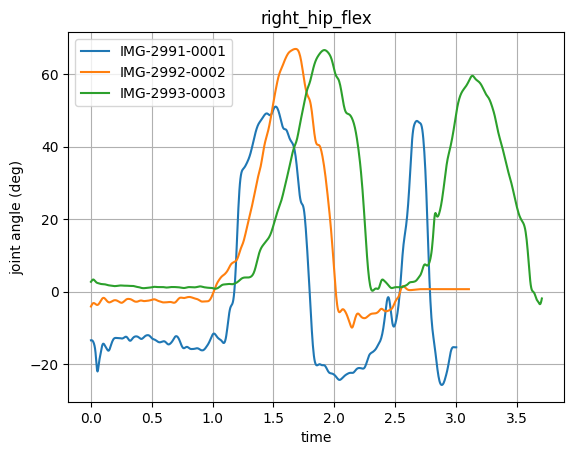

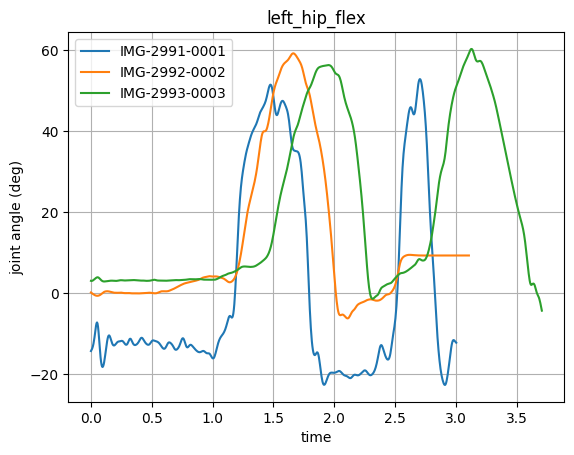

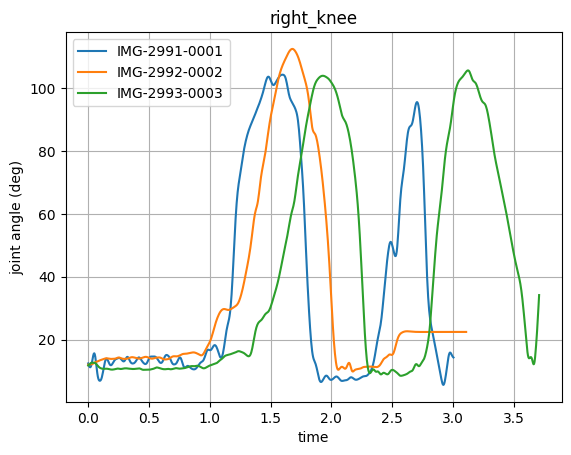

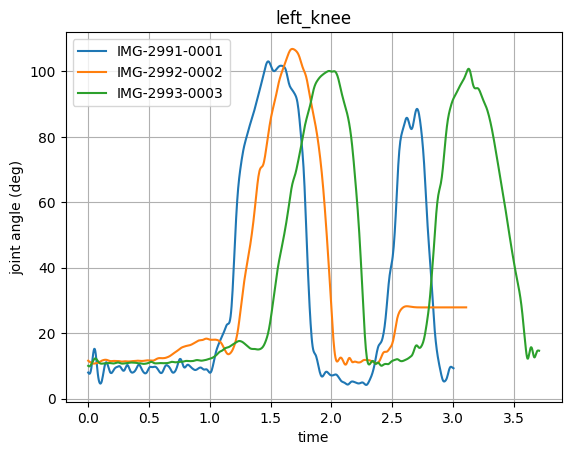

In [51]:
#@title Optional - Create Simple Comparison Plots

# Available time options for the x_column include: 'time_from_max_hand', 'norm_time', 'rel_frame', 'time'
# Note if analyzing basketball, "time_from..." column is 'time_from_max_height'
x_column = 'time'

# Below are examples of possible joint angles of interest for a left-handed pitcher,
# feel free to update to any available data from the INVERSE KINEMATICS file type here https://docs.rebootmotion.com/,
# or if your file type is MOMENTUM_ENERGY, you can update "y_columns" to columns from that file type
y_columns = [
    'right_hip_flex', 'left_hip_flex',
    'right_knee', 'left_knee'
]

# Set the y-axis label to whatever is appropriate for the y-columns above
y_axis_label = "joint angle (deg)"

mpl_figs = []

for y_column in y_columns:

    mpl_fig = plt.figure()

    for org_movement_id in primary_segment_data_df['org_movement_id'].unique():
        movement_df = (
            primary_segment_data_df.loc[primary_segment_data_df["org_movement_id"] == org_movement_id]
            .copy()
            .reset_index(drop=True)
        )

        plt.plot(movement_df[x_column], movement_df[y_column], label=org_movement_id)

    plt.ylabel(y_axis_label)
    # plt.ylim([-180, 180])  # uncomment to limit the height of the y-axis

    plt.xlabel(x_column)
    # plt.xlim([-1, 0.1])  # uncomment to limit the width of the x-axis

    plt.title(y_column)

    plt.legend()

    plt.grid()

    plt.show()

    mpl_figs.append(mpl_fig)

In [52]:
#@title Optional - Save Plots to a PDF

from matplotlib.backends.backend_pdf import PdfPages

pdf_file_name = 'analysis.pdf'

pdf_analysis = PdfPages(pdf_file_name)

for mpl_fig in mpl_figs:

    pdf_analysis.savefig(mpl_fig)

pdf_analysis.close()

print('Saved plots to', pdf_file_name)

Saved plots to analysis.pdf
